In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [13]:
import os
import pprint as pp

import contextily as cx
import matplotlib.pyplot as plt
import networkx as nx
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import teotil3 as teo

In [14]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Task 2.5: Estimate retention coefficients

## Part C: Exploring transmission of nutrients to the coast

This notebook was prompted by a question from Marianne Bechmann received 29.09.2022:

> When I’m talking about nitrogen loss from agriculture and the problems in the Oslofjord, people often ask how much retention we include from source (= agricultural land) to the fjord. The nitrogen loss from e.g. an agricultural area around Hamar, will it be reduced by 50 % before it reaches the Ytre Oslofjord or is the retention much less in the existing Teotil?

This is an interesting question, and it's worth exploring in the context of updating the retention coefficients for the new model. In particular, the old TEOTIL only considers retention in lakes (not rivers), and for large vassdragsområder river retention is likely to be significant. We have discussed this previously with Miljødirektoratet (see [NIVA Report 7726-2022](https://niva.brage.unit.no/niva-xmlui/bitstream/handle/11250/2985726/7726-2022%2bhigh.pdf?sequence=1&isAllowed=y) for details) and decided that including river retention is not within scope for the current development work. However, we may consider adding it during the next stage of development, after we've compared results from the new model to measured fluxes for major catchments from Elveovervåkingsprogrammet.

For now, this notebook will focus on answering Marianne's question, but generalised to consider all regine catchments.

## 1. Create input file

The code below creates an input file using the new model code. Estimates of lake volume and residenc times have been updated as part of [Task 2.4](https://github.com/NIVANorge/teotil3/tree/main/notebooks/development#task-24-estimate-residence-times) and the retention coefficients have been updated in [Task 2.5](https://github.com/NIVANorge/teotil3/tree/main/notebooks/development#task-25-estimating-retention).

In [15]:
# Define datasets to use
model_year = 2021
nve_data_delivery_year = 2023

# Output paths
data_fold = f"/home/jovyan/shared/common/teotil3/core_data"
teo_gpkg = os.path.join(data_fold, "tidied", "teotil3_data.gpkg")

In [18]:
# Make input dataframe
gdf = teo.io.make_input_file(
    model_year,
    nve_data_delivery_year,
    eng,
    out_csv_fold=None,
)

# Keep just relevant columns
cols = (
    ["regine", "regine_down", "vassom"]
    + [col for col in gdf.columns if col.startswith("trans_")]
    + ["geometry"]
)
gdf = gdf[cols]
gdf.head()

100.00 % of regines assigned.


In [6]:
# Build catchment hierarchy
g = teo.model.build_graph(gdf, id_col="regine", next_down_col="regine_down")

## 2. Calculate overall transmission to the coast/border

For each regine and parameter in the new model, the code below traces downstream to the coast/border and multiplies together all the transmission factors on the downstream path. This gives the overall transmission factor from each regine to the coast, expressed as a percentage.

In [7]:
# Calculate transmission to the coast/border
reg_list = []
par_list = [col.split("_")[-1] for col in gdf.columns if col.split("_")[0] == "trans"]
trans_to_border_dict = {par: [] for par in par_list}
for reg_nd in g.nodes:
    g_down = nx.dfs_tree(g, reg_nd)
    par_dict = {par: [] for par in par_list}
    for down_nd in list(nx.topological_sort(g_down))[:-1]:
        for par in par_list:
            par_dict[par].append(g.nodes[down_nd]["local"][f"trans_{par}"])
    reg_list.append(reg_nd)
    for par in par_list:
        trans_to_border_dict[par].append(np.round(100 * np.prod(par_dict[par]), 1))

df = pd.DataFrame(trans_to_border_dict)
df["regine"] = reg_list
df.describe()

,totp,tdp,tpp,totn,din,ton,ss,toc
count,24068.000000,24068.000000,24068.000000,24068.000000,24068.000000,24068.000000,24068.000000,24068.000000
mean,61.536355,72.172873,51.744794,88.619727,86.134448,95.433717,36.139679,66.089987
std,34.230137,27.638217,38.723818,16.565486,19.154300,8.197628,44.739001,30.865280
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.700000,50.900000,12.900000,84.100000,79.600000,94.500000,0.000000,39.500000
50%,64.200000,78.900000,45.400000,96.000000,94.800000,98.700000,3.700000,70.100000
75%,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [8]:
# Save
trans_gdf = pd.merge(gdf[["regine", "geometry"]], df, how="left", on="regine")
teo.io.geodataframe_to_geopackage(
    trans_gdf,
    teo_gpkg,
    "transmission_to_coast",
)

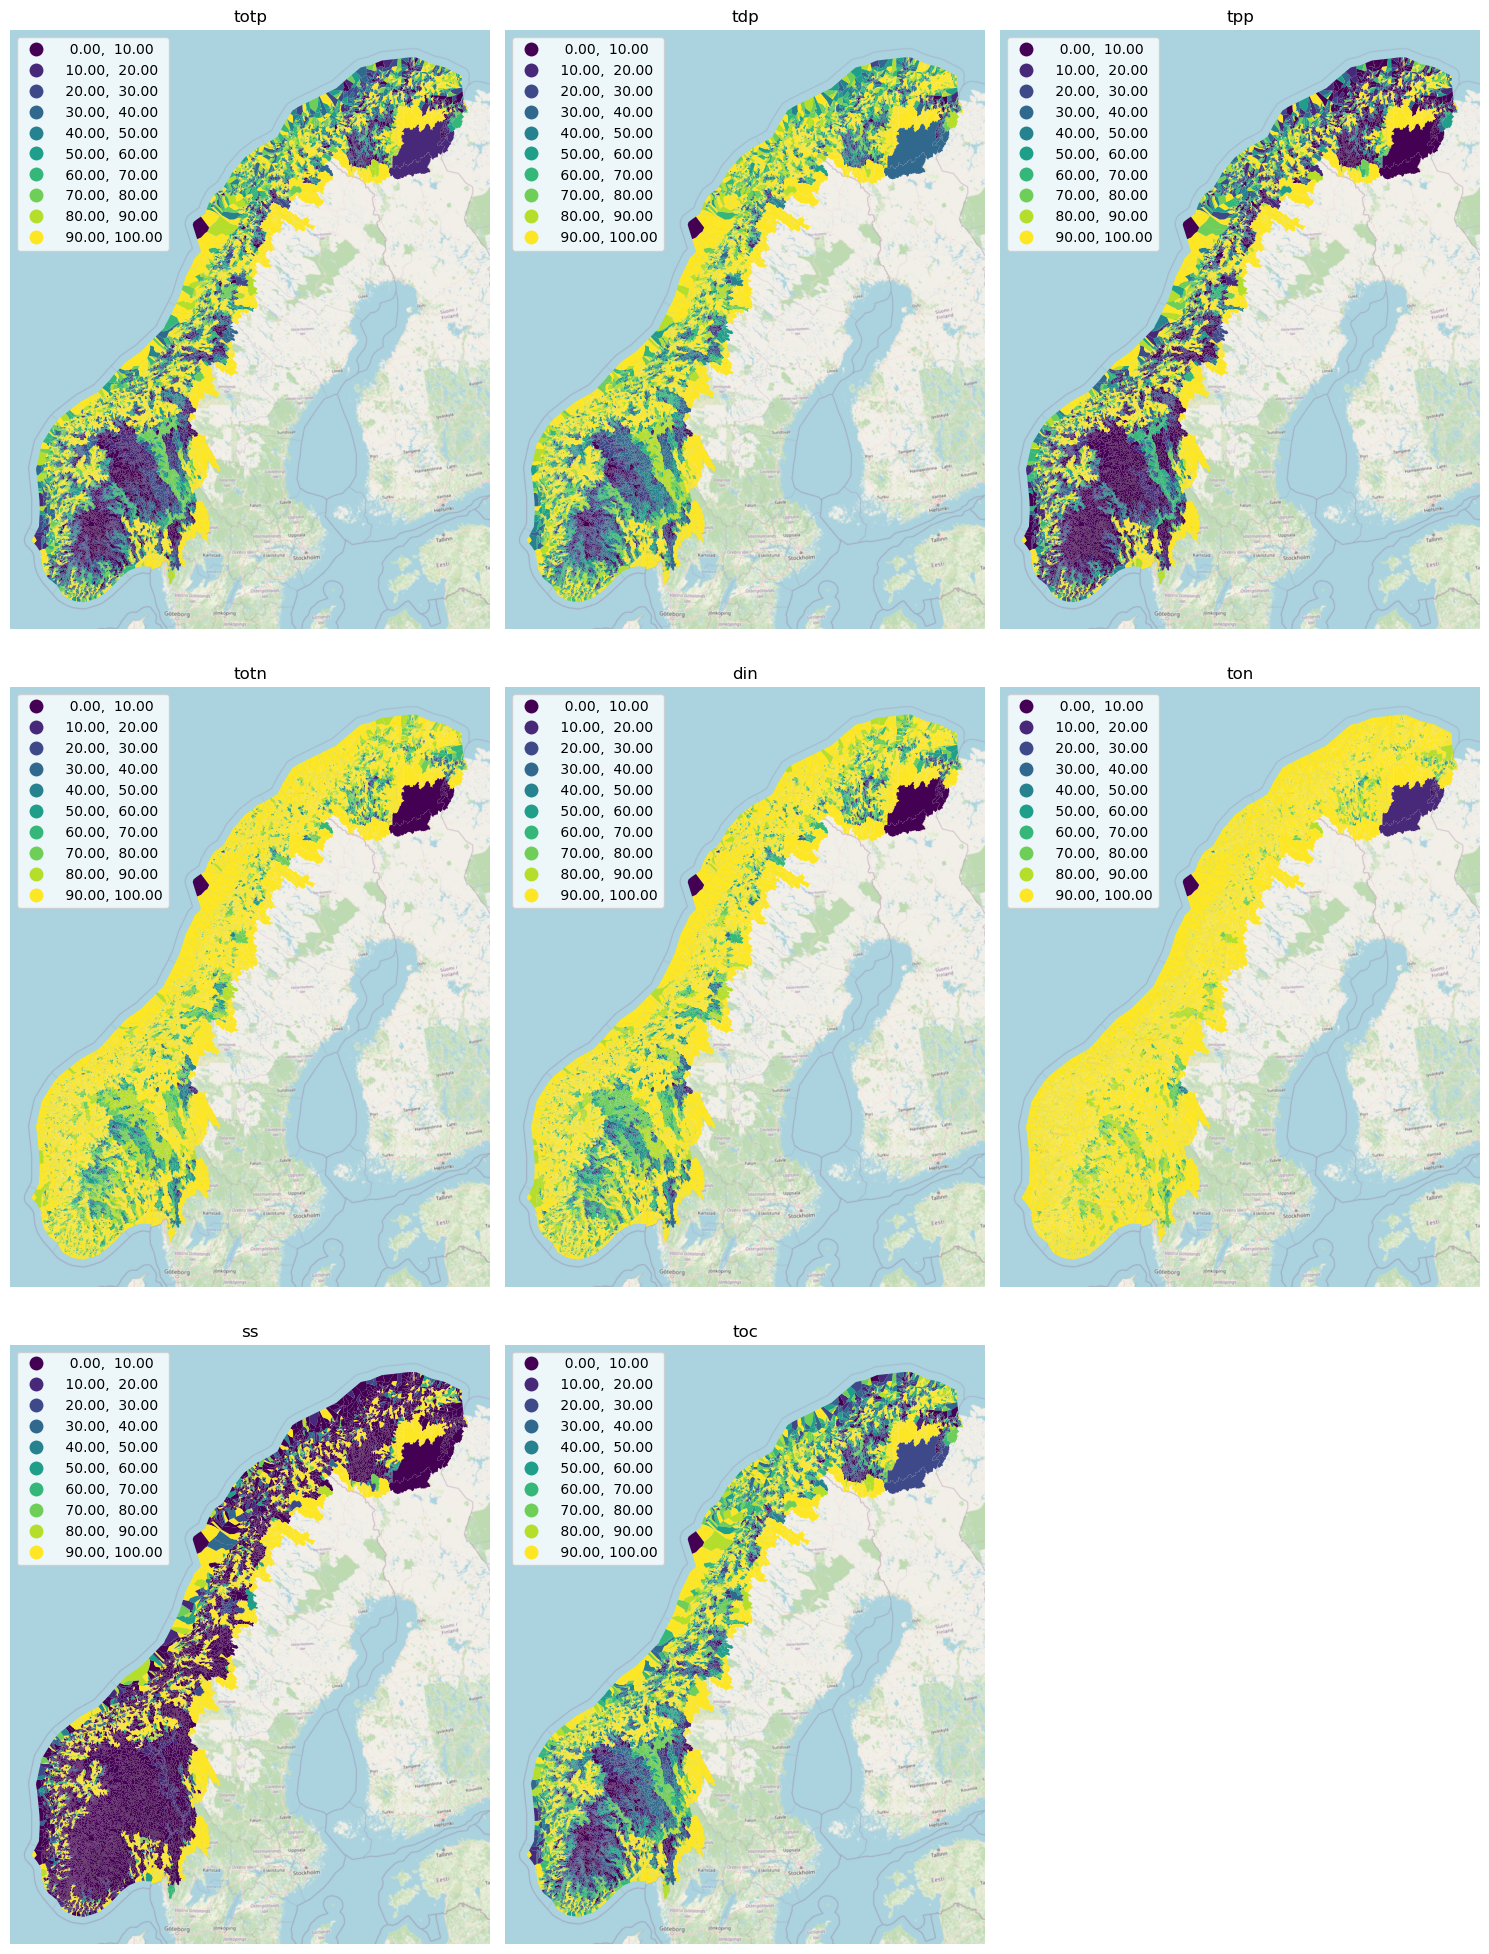

In [9]:
# Maps
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 20))
axes = axes.flatten()
plt.delaxes(ax=axes[-1])
for idx, par in enumerate(par_list):
    trans_gdf.plot(
        column=par,
        cmap="viridis",
        scheme="equal_interval",
        k=10,
        ax=axes[idx],
        legend=True,
        legend_kwds={"loc": "upper left"},
    )
    cx.add_basemap(
        axes[idx],
        crs=gdf.crs.to_string(),
        source=cx.providers.OpenStreetMap.Mapnik,
        attribution=False,
    )
    axes[idx].set_title(par)
    axes[idx].axis("off")
plt.tight_layout()

png_path = "../../images/transmission_to_coast.png"
plt.savefig(png_path, dpi=150)

The patterns on these maps reflect accumulated differences in the retention curves curves derived in the notebook for [Task 2.5a](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/development/T2-5a_est_vollenweider_params_from_data.ipynb). Note the following points:

 * **The maps for TOTN and TOTP are illustrative examples only**. As described in the notebook for [Task 2.5a](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/development/T2-5a_est_vollenweider_params_from_data.ipynb), transmission of TOTN and TOTP depends on the relative proportions of the subfractions. For example, if the TOTN is mostly DIN, the transmission will be more like the map for DIN; if it's mostly TON, it will behave like TON. The maps here assume typical fixed proportions, but for any real model application the transmission of TOTN and TOTP may vary compared to what is shown here
 
 * **Transmission of TOTN and TOTP is always in-between that for the subfractions**. For example, TDP has higher transmission than TPP, and TOTP is somewhere in the middle. Similarly, TON has higher transmission than DIN, and TOTN is in the middle. See the estimated retention curves in the plots at the end of [Section 7 of this notebook](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/development/T2-5a_est_vollenweider_params_from_data.ipynb#7.-Summary) for details 
 
 * **Transmission of SS is very low**. This is as expected, due to particle settling
 
 * In general, the patterns seem reasonable

### 2.1. Example for Hamar

To answer Marianne's question specifically, a quick look at [NVE Atlas](https://atlas.nve.no/Html5Viewer/index.html?viewer=nveatlas#) shows that regine `002.DC5B` is just north of Hamar. I don't know whether there's much agriculture here, but for this hypothetical experiment it doesn't matter. 

In [10]:
df.query("regine == '002.DC5B'")

,totp,tdp,tpp,totn,din,ton,ss,toc,regine
430,23.4,40.5,11.2,84.6,80.4,94.7,0.0,37.1,002.DC5B


So, for a typical regine near Hamar:

 * 41% of TDP and 11% of TPP make it to the Oslofjord. The proportion of TOTP can vary between these two estimates depending on the ratio of TPP:TDP, but a typical overall transmission factor for TOTP is 23%
 
 * 95% of TON and 80% of DIN make it to the Oslofjord. The proportion of TOTN can vary between these two estimates depending on the ratio of TON:DIN, but a typical overall transmission factor for TOTN is 85%
 
 * The amount of SS reaching the Oslofjord from Hamar is essentially zero
 
 * About 37% of TOC reaches the Oslofjord
 
**Note:** For comparison, an earlier version of this notebook used the original TEOTIL2 approach and estimated the TOTN transmisson from Hamar to be 82% i.e. broadly comparable to the plausible ranges for the new model given above. 